# Produced a Gaussian distribution in all degrees of freedom

In [11]:
import generatorTool as gt
import numpy as np
import numpy.random as rd 
import matplotlib.pyplot as plt
from scipy import constants
import makeopenpmd

# unit conversion:
mm=1e3

qElec  = constants.value(u'elementary charge')
mElec  = constants.value(u'electron mass')
qOm    = qElec/mElec
cLight = constants.value(u'speed of light in vacuum')



### Beam parameters setup

##### general parameters

In [2]:
n            = 100000  # number of macroparticles
lorentz_fac  = 120   # Lorentz factor
norm_emitx   = 10e-6  # normalized emittance in x
norm_emity   = 10e-6  # normalized emittance in y
nsigma       = 2  # cut [in # of sigmas] for the Gaussian distrib.
bunchCharge  =-2e-9

#### Compute Courant-Snyder parameter to focus the beam after a drift of D 

In [3]:
D         = 0.24  # location of waist
sizeStar  = 1.e-4  # RMS beam size at waist
betaxStar = (sizeStar)**2/(norm_emitx/lorentz_fac)
betayStar = (sizeStar)**2/(norm_emity/lorentz_fac)

betax     = betaxStar+D**2/betaxStar
betay     = betayStar+D**2/betayStar

alphax    = D/betaxStar
alphay    = D/betayStar

gammax    = (1+alphax**2)/betax
gammay    = (1+alphay**2)/betay

print ("betaxStar",betaxStar)
print ("betax",betax)
print ("alphax",alphax)


betaxStar 0.12
betax 0.6
alphax 2.0


Text(0, 0.5, 'RMS beam sizes (m)')

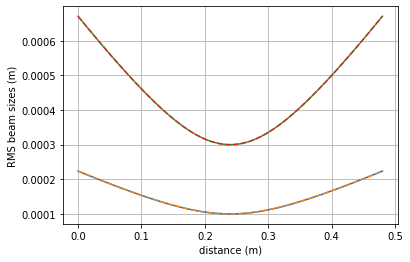

In [4]:
# check envelop
sCoor = np.linspace(0,2*D,101)

sigmX = np.sqrt((norm_emitx/lorentz_fac)*(betax+2*sCoor*(-alphax)+gammax*sCoor**2))
sigmY = np.sqrt((norm_emity/lorentz_fac)*(betay+2*sCoor*(-alphay)+gammay*sCoor**2))

plt.plot (sCoor,sigmX)
plt.plot (sCoor,sigmY,'--')
plt.plot (sCoor,3*sigmX)
plt.plot (sCoor,3*sigmY,'--')
plt.grid()
plt.xlabel ('distance (m)')
plt.ylabel ('RMS beam sizes (m)')


#### longitudinal phase space

In [5]:
dLorentz_fac = 1e-3*lorentz_fac   #        spread in Lorentzfactor
blength      = 1e-3
ddOverdz     = 0.0   # in m^-1 -- chirp (slope)


### Generating the simulation

In [6]:
# generate the Gaussian distribution in (x,x',y,y')
emitgeomx=norm_emitx/lorentz_fac
emitgeomy=norm_emity/lorentz_fac

x, xp, y, yp = gt.gaussian_phase_space_2dof(n, alphax, betax, emitgeomx,\
                                  alphay, betay, emitgeomy, nsigma)  

# generate the longitudinal phase space:
U=  gt.Gauss_2d_cart_cut(n,1e-10,2.0)

z    = blength*U[0,:]; 
# linearly-chirped longitudinal phase space
dp  = dLorentz_fac*U[1,:]+ ddOverdz*z

dpp =dp/lorentz_fac

#### plotting the results

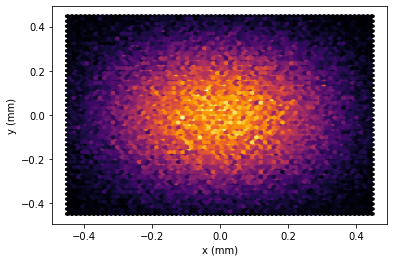

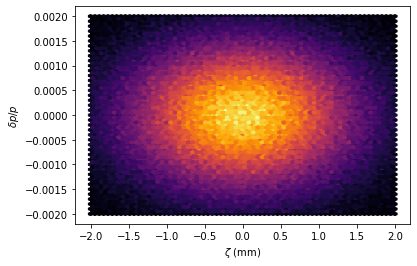

In [7]:
plt.hexbin (mm*x,mm*y, gridsize=70, cmap='inferno')
plt.xlabel('x (mm)')
plt.ylabel('y (mm)')
plt.show()
plt.hexbin (mm*z,dpp, gridsize=70, cmap='inferno')
#plt.plot (z,dpp,'.')
plt.xlabel(r'$\zeta$ (mm)')
plt.ylabel(r'$\delta p/p$ ')
plt.show()


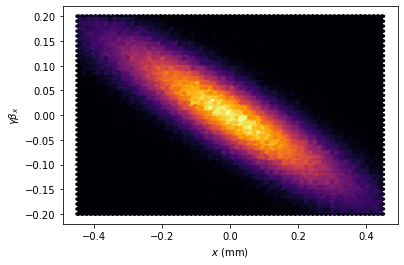

In [8]:
plt.hexbin (mm*x,xp*(1+dpp)*lorentz_fac, gridsize=70, cmap='inferno')
plt.xlabel(r'$x$ (mm)')
plt.ylabel(r'$\gamma\beta_x$')
plt.show()

### Saving to file in openPMD



In [9]:
# rewrite the momentum in units of gamma*beta_i 
# (assume relativistic beam here)/


px=xp*(1+dpp)*lorentz_fac
py=yp*(1+dpp)*lorentz_fac
pz=(1+dpp)*lorentz_fac

In [12]:
# dump into a warpX-readable file
# warpX wants SI units so

px *= mElec*cLight
py *= mElec*cLight
pz *= mElec*cLight

makeopenpmd.make_openPMD(x, y, z, px, py, pz, 'init.h5', bunchCharge)
